In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

In [3]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std


In [144]:
CS_THRESH = 0.05
OW_THRESH = -0.2
RATIO_THRESH = 1/3
SEARCH_RADIUS_MAX = 50000

eddy = the_frontier_eddies[0]
t = 15

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']
x = sample_data[eddy]['T'+str(t)]['x']
y = sample_data[eddy]['T'+str(t)]['y']
X, Y = np.meshgrid(x, y)

cs = np.sqrt(U**2 + V**2)
ow = normalize_matrix(calc_ow(U, V, x[1]-x[0], x[1]-x[0]))

xc, yc = 0, 0
xcs, ycs, zcs = [], [], []
A = np.array([[np.nan, np.nan], [np.nan, np.nan]])
bottom_flag = 0
depth_dic = {}
for depth_lvl in range(U.shape[-1]):
    Search_Radius = 5000
    flag = 0
    if not bottom_flag:
        while Search_Radius <= SEARCH_RADIUS_MAX:
            R = np.sqrt((X - xc)**2 + (Y - yc)**2)
            mask = R < Search_Radius
            cur_speed_masked = np.where(mask, cs[:, :, depth_lvl], np.nan) 
            ow_masked = np.where(mask, ow[:, :, depth_lvl], np.nan) 
            pot_i, pot_j = np.where((cur_speed_masked < CS_THRESH) & (ow_masked < OW_THRESH))
            ratio = len(pot_i) / np.sum(mask) if len(pot_i) != 0 else 0
            if ratio <= RATIO_THRESH and ratio != 0:
                A = np.array([x[pot_i], y[pot_j]])
                xc, yc = np.mean(A, axis=1)
                xcs.append(xc)
                ycs.append(yc)
                zcs.append(z_r[150, 150, depth_lvl])
                depth_dic['Depth'+str(depth_lvl)] = {'xc': xc, 'yc': yc, 
                                                     'Depth': z_r[150, 150, depth_lvl],
                                                     'pots': A, 'SR': Search_Radius
                                                    }
                flag = 1
                break
            Search_Radius += 5000
        if not flag:
            bottom_flag = 1
xcs, ycs, zcs = np.array(xcs), np.array(ycs), np.array(zcs)

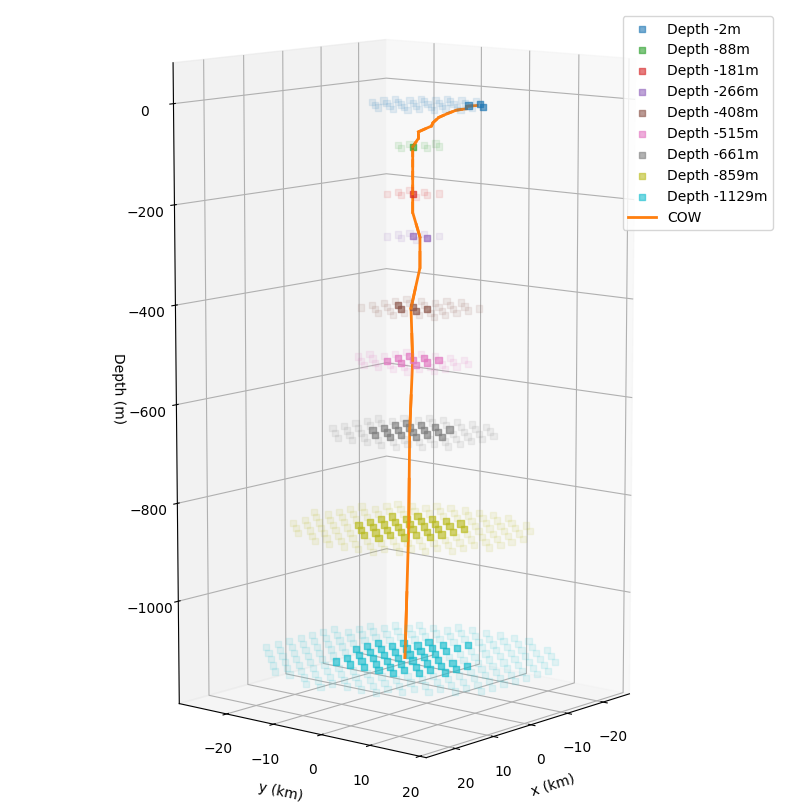

In [156]:
from mpl_toolkits.mplot3d import Axes3D  

X, Y = np.meshgrid(np.arange(-150, 150, 3),
                      np.arange(-150, 150, 3))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.tab10.colors * 3
for i, depth_lvl in enumerate(idx for idx in range(len(depth_dic)) if idx not in [1,2,3,4, 5,6, 7,8, 9, 11, 17, 15, 13, 12]):
# for i, depth_lvl in enumerate([0,12,16, 19, 21]):
# for i, depth_lvl in enumerate(range(len(depth_dic))):
    if i > 0:
        i += 1
    data = depth_dic['Depth' + str(depth_lvl)]
    A = data['pots']/1000
    xc = data['xc']/1000
    yc = data['yc']/1000
    z = data['Depth']
    SR = data['SR']/1000
    if depth_lvl == 0:
        xc_pre, yc_pre = 0, 0
    else:
        pre_data = depth_dic['Depth' + str(depth_lvl-1)]
        xc_pre, yc_pre = pre_data['xc']/1000, pre_data['yc']/1000
    R = np.hypot(X-xc_pre, Y-yc_pre)
    X_masked = np.where(R < SR, X, np.nan)
    Y_masked = np.where(R < SR, Y, np.nan)
    ax.scatter(X_masked, Y_masked, [z] * (X_masked.shape[0]*X_masked.shape[1]), marker='s', alpha=0.1, color=colors[i]) 
    # ax.scatter(xc, yc, z, label=f'Depth {round(z_r[150,150,depth_lvl])}m', alpha=0.6, color=colors[i]) 
    ax.scatter(A[0, :], A[1, :], [z] * len(A[0, :]), marker='s', alpha=0.6, color=colors[i], label=f'Depth {round(z_r[150,150,depth_lvl])}m') 
ax.plot(xcs/1000, ycs/1000, zcs, zorder=0, linewidth=2, color=colors[1], label='COW')
for i in range(1, len(xcs)):
    x_mid = (xcs[i]+xcs[i-1])/2 / 1000
    y_mid = (ycs[i]+ycs[i-1])/2 / 1000
    z_mid = (zcs[i]+zcs[i-1])/2 
    ax.plot([xcs[i]/1000, x_mid], [ycs[i]/1000, y_mid], [zcs[i], z_mid], linewidth=2, color=colors[1],zorder=10)
    
ax.view_init(elev=10, azim=40) #350
ax.set_box_aspect([1, 1, 2]) 
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_zlabel("Depth (m)", labelpad=15)
ax.legend()
ax.tick_params(axis='z', direction='in', length=6, pad=10)  # Adjust 'pad' value for left/right positioning
plt.show()